# Линейная алгебра и приложения

## Иерархический кластерный анализ: количественные данные

*Алла Тамбовцева*

### Подготовка к работе

Импортируем необходимые библиотеки, модули и функции:

* библиотеку `pandas` для обработки данных;
* модуль `pyplot` из `matplotlib` и библиотеку `seaborn` для графики;
* функцию `StandardScaler()` для нормирования данных;
* функции `linkage()`, `dendrogram()`, `cut_tree()` для реализации иерархического кластерного анализа.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

Загрузим данные из файла `flats_cian_upd.csv` – выгрузка с ЦИАН по квартирам в Москве:

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/allatambov/LinStat25/refs/heads/main/flats_cian_upd.csv")
print(df.shape)

(10054, 14)


In [3]:
df.head()

,price,lprice,square,rooms,floor,mfloor,station,metro,ametro,dmetro,link,add,lat,lon
0,12000000,16.300417,60.0,3,1,9,метро Аннино,6 минут на транспорте,0,6,https://www.cian.ru/sale/flat/314948168/,"Чертановская ул., 66К2",55.596930,37.585664
1,11499999,16.257858,37.9,1,16,20,метро Аннино,19 минут пешком,1,19,https://www.cian.ru/sale/flat/315677385/,"ул. Газопровод, 15",55.589274,37.612650
2,36000000,17.399029,120.0,4,1,9,метро Аннино,7 минут на транспорте,0,7,https://www.cian.ru/sale/flat/309425036/,"Старокачаловская ул., 14",55.569708,37.587596
3,13490000,16.417459,48.8,2,10,12,метро Аннино,15 минут пешком,1,15,https://www.cian.ru/sale/flat/316119734/,"ул. Газопровод, 3К1",55.592418,37.604187
4,11900000,16.292049,41.9,1,14,14,метро Аннино,16 минут пешком,1,16,https://www.cian.ru/sale/flat/316733228/,"Старобитцевская ул., 15К1",55.575022,37.586338


В датафрейме 10054 строк и 14 столбцов. Переменные в файле:

* `price`: цена в рублях;
* `lprice`: логарифм цены;
* `square`: площадь квартиры, в кв. метрах;
* `rooms`: число комнат;
* `floor`: этаж;
* `mfloor`: число этажей в доме;
* `station`: станция метро;
* `metro`: доступность и расстояние до метро;
* `ametro`: шаговая доступность метро (1 – да, 0 – нет);
* `dmetro`: расстояние до метро (на транспорте или пешком), в минутах;
* `link`: ссылка на объявление;
* `add`: адрес;
* `lat`: широта;
* `lon`: долгота.

Посмотрим на описательные статистики:

In [4]:
df.describe()

,price,lprice,square,rooms,floor,mfloor,ametro,dmetro,lat,lon
count,1.005400e+04,10054.000000,10054.000000,10054.000000,10054.000000,10054.000000,10054.000000,10054.000000,10054.000000,10054.000000
mean,4.781103e+07,17.140662,74.339765,2.362443,8.278496,15.897951,0.697832,11.159240,55.723913,37.582846
std,8.397270e+07,0.883976,48.774702,1.045435,7.306673,9.957861,0.459221,5.483035,0.081416,0.119278
min,3.200000e+06,14.978661,10.700000,1.000000,1.000000,1.000000,0.000000,1.000000,55.433614,37.151868
25%,1.450000e+07,16.489659,44.000000,2.000000,3.000000,9.000000,0.000000,6.000000,55.674975,37.496704
50%,2.192500e+07,16.903137,60.000000,2.000000,6.000000,14.000000,1.000000,11.000000,55.730892,37.588027
75%,4.300000e+07,17.576711,84.000000,3.000000,11.000000,21.000000,1.000000,16.000000,55.773756,37.653209
max,1.732171e+09,21.272641,779.400000,5.000000,80.000000,95.000000,1.000000,90.000000,55.936000,37.972533


Судя по описательным статистикам, в данных есть нехарактерные значения – нетипично большие и дорогие квартиры. Проверим, что такие значения – не результат ошибки:

In [5]:
# 5-комнатная квартира рядом с Площадью Революции
df[df["price"] == df["price"].max()]

,price,lprice,square,rooms,floor,mfloor,station,metro,ametro,dmetro,link,add,lat,lon
4144,1732170835,21.272641,392.1,5,5,5,метро Площадь Революции,16 минут пешком,1,16,https://www.cian.ru/sale/flat/300661842/,"Газетный пер., 13С1",55.758894,37.609398


In [6]:
# 4-комнатная квартира площади 779 м^2 на Живописной улице
df[df["square"] == df["square"].max()]

,price,lprice,square,rooms,floor,mfloor,station,metro,ametro,dmetro,link,add,lat,lon
9888,661239200,20.309626,779.4,4,1,22,метро Щукинская,7 минут на транспорте,0,7,https://www.cian.ru/sale/flat/313701425/,"Живописная ул., 21А",55.793333,37.448554


Удалять такие наблюдения не будем, как раз большое и дорогое жилье выделится в отдельный кластер «элитного жилья». Однако чтобы не тратить много времени на запуск кластеризации более 10000 точек, случайным образом выберем 30 квартир в окрестности каждой станции метро:

In [7]:
# таблица частот
tab = df["station"].value_counts()
tab

метро Площадь Ильича       246
метро Киевская             227
метро Войковская           224
метро Люблино              222
метро Площадь Революции    202
                          ... 
метро Лубянка                2
метро Озёрная                2
метро Жулебино               1
метро Царицыно               1
метро Домодедовская          1
Name: station, Length: 146, dtype: int64

In [8]:
# выбираем те станции, где квартир более 30
# забираем их названия – index

stations = tab[tab > 30].index
print(stations)

Index(['метро Площадь Ильича', 'метро Киевская', 'метро Войковская',
       'метро Люблино', 'метро Площадь Революции', 'метро Добрынинская',
       'метро Лианозово', 'метро Дмитровская', 'метро Рязанский проспект',
       'метро Кантемировская', 'метро Спортивная', 'метро Воронцовская',
       'метро Алексеевская', 'метро Ясенево', 'метро Октябрьское Поле',
       'метро Раменки', 'метро Марьина Роща', 'метро Варшавская',
       'метро Аэропорт', 'метро Марксистская', 'метро Парк культуры',
       'метро Шаболовская', 'метро Улица Горчакова', 'метро Минская',
       'метро Крылатское', 'метро Южная', 'метро Коломенская',
       'метро Новопеределкино', 'метро Кутузовская', 'метро Красносельская',
       'метро Новогиреево', 'метро Щукинская', 'метро Нахимовский проспект',
       'метро Нижегородская', 'метро Аннино', 'метро Волгоградский проспект',
       'метро Саларьево', 'метро Автозаводская', 'метро Славянский бульвар',
       'метро Строгино', 'метро Яхромская', 'метро Фрунзенск

In [9]:
# отбираем в chosen те квартиры, которые входят
# в список stations

chosen = df[df["station"].isin(stations)]

In [10]:
# группируем квартиры по станции метро,
# извлекаем случайные выборки объема 30 из каждой группы
# random_state = 1234 – для воспроизводимости, чтобы
# у всех были одинаковые результаты

flats = chosen.groupby("station").sample(30, random_state = 1234)

Получили выборку из 2640 квартир:

In [11]:
print(flats.shape)
flats.head()

(2640, 14)


,price,lprice,square,rooms,floor,mfloor,station,metro,ametro,dmetro,link,add,lat,lon
7187,23700000,16.980986,96.0,3,5,5,метро Авиамоторная,3 минуты пешком,1,3,https://www.cian.ru/sale/flat/285592167/,"2-я Кабельная ул., 10",55.748503,37.717321
7197,25000000,17.034386,56.0,2,5,27,метро Авиамоторная,10 минут пешком,1,10,https://www.cian.ru/sale/flat/300255349/,"ул. Крузенштерна, 12к2",55.750859,37.705679
7198,16650000,16.627921,37.6,1,9,26,метро Авиамоторная,8 минут пешком,1,8,https://www.cian.ru/sale/flat/312014646/,"ул. Крузенштерна, 12к3",55.750844,37.706622
7173,21500000,16.883563,65.2,2,6,12,метро Авиамоторная,2 минуты пешком,1,2,https://www.cian.ru/sale/flat/314423601/,"ш. Энтузиастов, 15/16",55.751822,37.716153
7171,39999000,17.504365,76.9,3,8,19,метро Авиамоторная,10 минут пешком,1,10,https://www.cian.ru/sale/flat/314629959/,"Красноказарменная ул., 14Ак2",55.753230,37.706973


### Нормирование данных

Выберем столбцы, на основе которых мы будет кластеризовать квартиры:

* логарифм цены;
* площадь квартиры;
* число комнат;
* этаж;
* расстояние до метро.

In [12]:
small = flats[["lprice", "square", "rooms", "floor", "dmetro"]]
small.head()

,lprice,square,rooms,floor,dmetro
7187,16.980986,96.0,3,5,3
7197,17.034386,56.0,2,5,10
7198,16.627921,37.6,1,9,8
7173,16.883563,65.2,2,6,2
7171,17.504365,76.9,3,8,10


В качестве способа шкалирования данных выберем *стандартизацию* – вычитание среднего и деление на стандартное отклонение, поскольку все показатели в количественной шкале (даже в абсолютной шкале). Создадим объект класса `StandardScaler()`, зарезервируем место под результаты, а затем применим метод `fit_transform()`:

* часть `fit` отвечает за оценку параметров, в данном случае расчет среднего и стандартного отклонения для каждого столбца;
* часть `transform` отвечает за преобразование, в данном случае за вычитание среднего и деление на стандартное отклонение.

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(small)
X

array([[-0.15557587,  0.47159832,  0.61837885, -0.44948893, -1.51048184],
       [-0.09542146, -0.36351728, -0.33241915, -0.44948893, -0.21901777],
       [-0.55329305, -0.74767045, -1.28321714,  0.08371744, -0.58800751],
       ...,
       [-0.07311438, -0.02529546,  0.61837885,  0.48362222, -1.14149211],
       [-0.56348742, -0.40944863, -0.33241915,  1.01682859, -1.14149211],
       [-0.47174728, -0.27374235, -0.33241915, -0.84939371, -0.77250237]])

В `X` сохранен массив стандартизованных значений (тип *датафрейм* теряем, но некритично, это те же пять столбцов с данными для Python). Всё готово к работе!

### Иерархический кластерный анализ

Попробуем реализовать иерархический кластерный анализ с настройками по-умолчанию – в `linkage()` будет использовано евклидово расстояние и метод ближнего соседа (метод одиночной связи): 

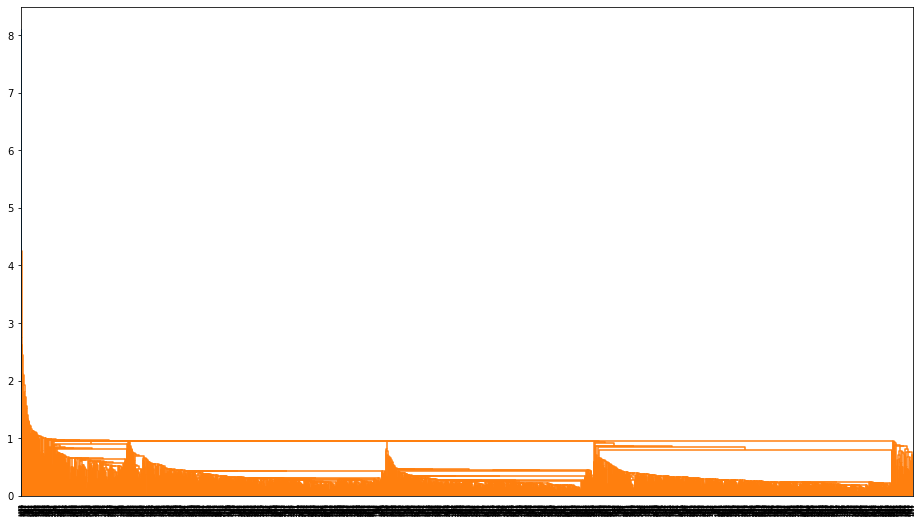

In [14]:
# method = 'single'
# реализуем и сразу строим дендрограмму размера 16 на 9 дюймов

hc = linkage(X)

plt.figure(figsize = (16, 9))
dendrogram(hc);

Очевидно, что идея использовать такие параметры кластеризации – плохая. Метод ближнего соседа отличается тем, что он склонен образовывать монокластеры – кластеры из одного наблюдения. Здесь так и вышло, у дерева много висячих вершин, отсюда отсутствие более крупных групп, Python даже цветом рекомендует выделить один огромный кластер из всех квартир :)

Изменим метод агрегирования на метод дальнего соседа (полной связи):

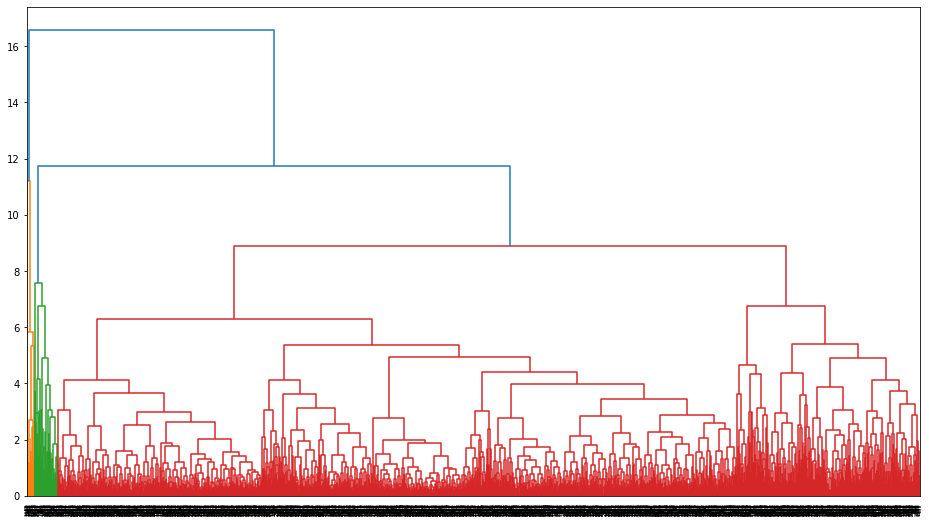

In [15]:
hc = linkage(X, method = "complete")

plt.figure(figsize = (16, 9))
dendrogram(hc);

Уже получше, но один из кластеров получился уж слишком большим, «растянутым». Понятно, что в него будут попадать очень разнообразные квартиры, а мы хотим получить более однородные кластеры. Попробуем самый эффективный метод – метод Варда (Уорда):

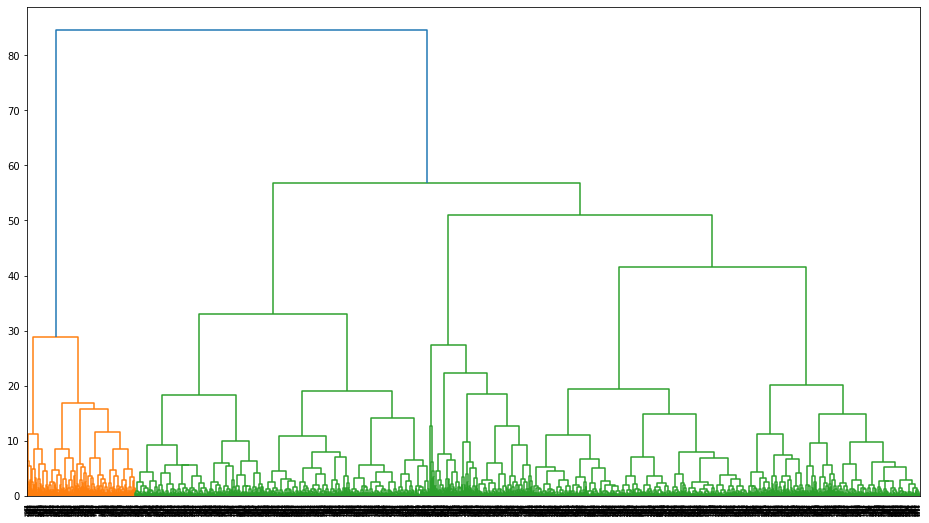

In [16]:
hc = linkage(X, method = "ward")

plt.figure(figsize = (16, 9))
dendrogram(hc);

Вот теперь это похоже на что-то разумное. Выделим три кластера – «разрежем» дендрограмму примерно по расстоянию 55:

In [17]:
# разрезаем дендрограмму на три ветки-группы
cut_tree(hc, n_clusters = 3)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Результат выше – метки кластеров, номера групп от 0 до 2 включительно. Однако они хранятся внутри вложенного массива, то есть с «лишними» квадратными скобками внутри. Уберем это ненужное измерение, применив метод `.reshape()`:

In [18]:
# убираем одно измерение и получаем обычный массив как список
clusters_ = cut_tree(hc, n_clusters = 3).reshape(-1, )
clusters_

array([0, 0, 0, ..., 0, 0, 0])

**Пояснение.** Посмотрим на размерность исходного массива:

In [19]:
print(cut_tree(hc, n_clusters = 3).shape)

(2640, 1)


Число 1 здесь можно интерпретировать как число списков в каждой строке. Мы хотим от этих списков избавиться, чтобы получить обычный перечень значений, поэтому в `.reshape()` указываем значение `-1`. В итоге получается массив размерности 2640 на 0, что в рамках NumPy соответствует одномерным массивам, похожим на обычные списки в Python.

Добавим в датафрейм `flats` столбец `cluster_c` с полученными номерами кластеров, только прежде сделаем эти метки текстовыми. Никто не запрещает нумеровать кластеры целыми числами, но далее мы будем строить графики, и если мы будем раскрашивать точки, соответствующие разным кластерам, разными цветами, в случае числового номера Python будет делать градиентную растяжку от бледного цвета к яркому, что здесь неуместно.

In [20]:
# превращаем integer в string
flats["cluster_c"] = clusters_.astype(str)
flats.head(10)

,price,lprice,square,rooms,floor,mfloor,station,metro,ametro,dmetro,link,add,lat,lon,cluster_c
7187,23700000,16.980986,96.0,3,5,5,метро Авиамоторная,3 минуты пешком,1,3,https://www.cian.ru/sale/flat/285592167/,"2-я Кабельная ул., 10",55.748503,37.717321,0
7197,25000000,17.034386,56.0,2,5,27,метро Авиамоторная,10 минут пешком,1,10,https://www.cian.ru/sale/flat/300255349/,"ул. Крузенштерна, 12к2",55.750859,37.705679,0
7198,16650000,16.627921,37.6,1,9,26,метро Авиамоторная,8 минут пешком,1,8,https://www.cian.ru/sale/flat/312014646/,"ул. Крузенштерна, 12к3",55.750844,37.706622,0
7173,21500000,16.883563,65.2,2,6,12,метро Авиамоторная,2 минуты пешком,1,2,https://www.cian.ru/sale/flat/314423601/,"ш. Энтузиастов, 15/16",55.751822,37.716153,0
7171,39999000,17.504365,76.9,3,8,19,метро Авиамоторная,10 минут пешком,1,10,https://www.cian.ru/sale/flat/314629959/,"Красноказарменная ул., 14Ак2",55.753230,37.706973,0
7221,37000000,17.426428,74.2,2,10,16,метро Авиамоторная,14 минут пешком,1,14,https://www.cian.ru/sale/flat/308281145/,"проезд Невельского, 6к1",55.751102,37.700361,0
7205,43000000,17.576711,104.4,3,21,27,метро Авиамоторная,12 минут пешком,1,12,https://www.cian.ru/sale/flat/309237591/,"проезд Невельского, 6к3",55.751898,37.702086,1
7185,13500000,16.418200,43.6,2,2,5,метро Авиамоторная,7 минут на транспорте,0,7,https://www.cian.ru/sale/flat/315083707/,"Подъемная ул., 6Б",55.739397,37.707691,0
7169,14570000,16.494475,43.5,2,2,5,метро Авиамоторная,2 минуты пешком,1,2,https://www.cian.ru/sale/flat/312580282/,"ш. Энтузиастов, 20Б",55.749993,37.715498,0
7186,26500000,17.092655,78.0,3,6,8,метро Авиамоторная,1 минута пешком,1,1,https://www.cian.ru/sale/flat/314422824/,"ш. Энтузиастов, 13",55.751614,37.714968,0


### Анализ результатов

Сгруппируем квартиры по полученным меткам кластеров `cluster_c` и посмотрим на описательные статистики ключевых показателей по каждой группе:

In [21]:
# группируем по cluster_c
# выбираем столбец price/square/floor
# запрашиваем в agg характеристики

print(flats.groupby("cluster_c")["price"].agg(["count", "mean", "min", "max"]))
print(flats.groupby("cluster_c")["square"].agg(["count", "mean", "min", "max"]))
print(flats.groupby("cluster_c")["floor"].agg(["count", "mean", "min", "max"]))

           count          mean       min         max
cluster_c                                           
0           1447  2.875751e+07   3200000   958179500
1            320  1.911689e+08  31990000  1131400800
2            873  2.511140e+07   5990000   250000000
           count        mean   min    max
cluster_c                                
0           1447   63.401175  10.7  593.3
1            320  169.244375  74.4  493.2
2            873   54.876174  16.9  109.7
           count      mean  min  max
cluster_c                           
0           1447  9.536282    1   69
1            320  8.103125    1   31
2            873  6.540664    1   25


Итак, в первом кластере с номером 0 больше всего квартир, это не самые дорогие квартиры с разнообразными значениями площади (от 10.7 до 593.3 кв. метров) и находящиеся в довольно разных домах (в среднем, квартиры на 10 этаже, но есть и те, что в домах не менее 69 этажей). 

Второй кластер с номером 1 самый маленький. Это, как и ожидалось, элитная недвижимость с очень высокой стоимостью, площадью не менее 74.4 кв. метров. 

Третий кластер с номером 2 – условно «среднестатистические» квартиры, достаточно многочисленные, со средней площадью 55 кв. метров (при этом площадь не выше 109.7 кв. метров) и с самой низкой средней стоимостью 25 миллионов рублей.

Визуализируем полученные результаты – построим ящики с усами:

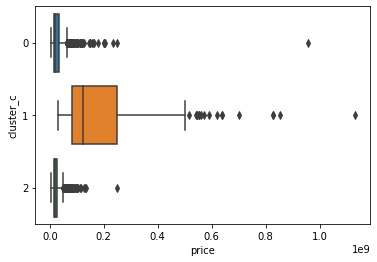

In [22]:
sns.boxplot(x = "price", y = "cluster_c", data = flats);

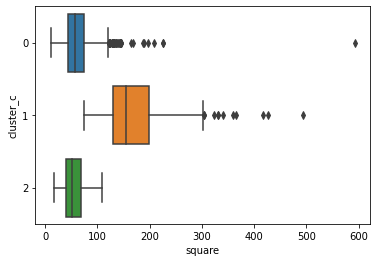

In [23]:
sns.boxplot(x = "square", y = "cluster_c", data = flats);

О чем нам говорят полученные графики? Во-первых, распределение цены и площади в каждом кластере скошено вправо, несимметрично. А значит, если мы захотим запустить формальные тесты для проверки различий в группах, нам понадобятся непараметрические варианты, не предполагающие нормального распределения. Так, показать, что распределения цены и площади неодинаковы, мы сможем с помощью [критерия](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html) Краскела-Уоллиса вместо классической ANOVA для сравнения средних. 

Во-вторых, в каждой группе есть выбросы, и их достаточно много. Это можно интерпретировать как сигнал о том, что, возможно, выбранное нами число кластеров мало, внутри каждой группы можно выделить как минимум еще две – типичные и нетипичные значения. Если в наши задачи входило получение довольно общей классификации, трех кластеров достаточно, но вообще можно попробовать выделить 5-6 кластеров, чтобы нехарактерные наблюдения были сформированы в отдельные более маленькие группы. Если вернемся к дендрограмме, заметим, что при «разрезе» по расстоянию примерно 35 получим как раз 5 групп.

### Кластеры и география

Установим и импортируем библиотеку geopandas, это надстройка над `pandas`, которая позволяет загружать файлы с географической информацией (в частности, файлы `.geojson`) и отрисовывать карты.

In [25]:
#!pip install geopandas

In [26]:
import geopandas as gpd

В файле `Москва_Moscow.geojson` хранится географическая информация о районах Москвы – набор точек для определения и отрисовки границ района ([источник](https://github.com/timurkanaz/Russia_geojson_OSM/tree/master/GeoJson's) данных, там есть федеральные округа с делением на регионы и регионы с делением на районы, при открытии geojson на Github все отображается в виде готовой карты).

При загрузке geojson-файла через функцию `read_file()` данные внешне ничем не отличаются от обычного датафрейма `pandas`:

In [27]:
df_geo = gpd.read_file("https://raw.githubusercontent.com/allatambov/LinStat25/refs/heads/main/%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0_Moscow.geojson")
df_geo.head()

,district,geometry
0,район Богородское,"POLYGON ((37.67021 55.83874, 37.67023 55.83865..."
1,район Вешняки,"POLYGON ((37.76730 55.73427, 37.76752 55.73415..."
2,район Восточное Измайлово,"POLYGON ((37.79943 55.79324, 37.79943 55.79322..."
3,район Восточный,"MULTIPOLYGON (((37.84533 55.81356, 37.84981 55..."
4,район Гольяново,"POLYGON ((37.74593 55.80903, 37.74604 55.80698..."


Каждый район – это отдельный объект на карте. Чисто геометрически, этот объект – многоугольник, то есть какая-то область, ограниченная замкнутой ломаной линией, *polygon* на английском языке. Поэтому здесь в таблице в столбце `geometry` хранятся объекты специального типа *POLYGON*, которые внутри похожи на кортежи с парными координатами точек (широта и долгота) в выбранной географической проекции. По этим точкам район отрисовывается на карте. В столбце `geometry` также есть объекты типа *MULTIPOLYGON* для больших районов или районов со сложными границами, которые удобнее собрать из нескольких многоугольников.

К такому более продвинутому датафрейму типа *GeoDataFrame* можно применить метод `.plot()` и построить карту!

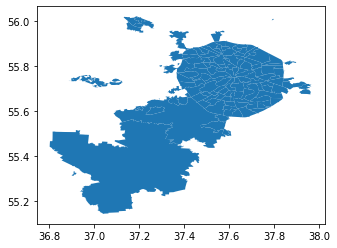

In [28]:
df_geo.plot();

Или метод `boundary.plot()` для отрисовки только границ без заливки:

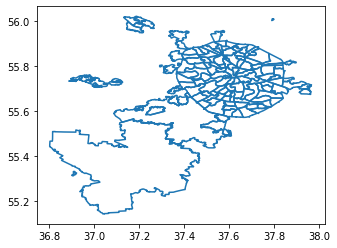

In [29]:
df_geo.boundary.plot();

Так как в данных, которые мы отобрали для кластерного анализа, нет районов Зеленограда и некоторых районов Новой Москвы (мы основывались на станциях метро, а с метро там не очень), уберем их с карты:

In [30]:
# список районов для удаления с карты

out = ["Троицкий административный округ", "район Кунцево", "район Силино", 
       "район Старое Крюково", "район Крюково",
       "район Матушкино", "район Савелки"]

# через ~ строим отрицание к результату isin()
# выбираем все, что не в out по столбцу district

df_geo = df_geo[~df_geo["district"].isin(out)]

Обновим карту:

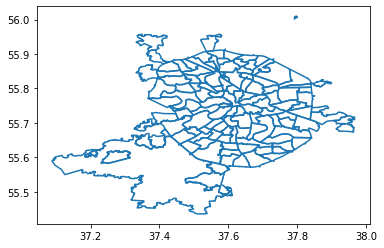

In [31]:
df_geo.boundary.plot();

Осталось нанести точки, соответствующие квартирам (у нас для них есть координаты – в столбцах `lon` и `lat`), на полученную карту. Для этого нужно в одних и тех же осях построить два графика – карту и диаграмму рассеивания с точками-квартирами:

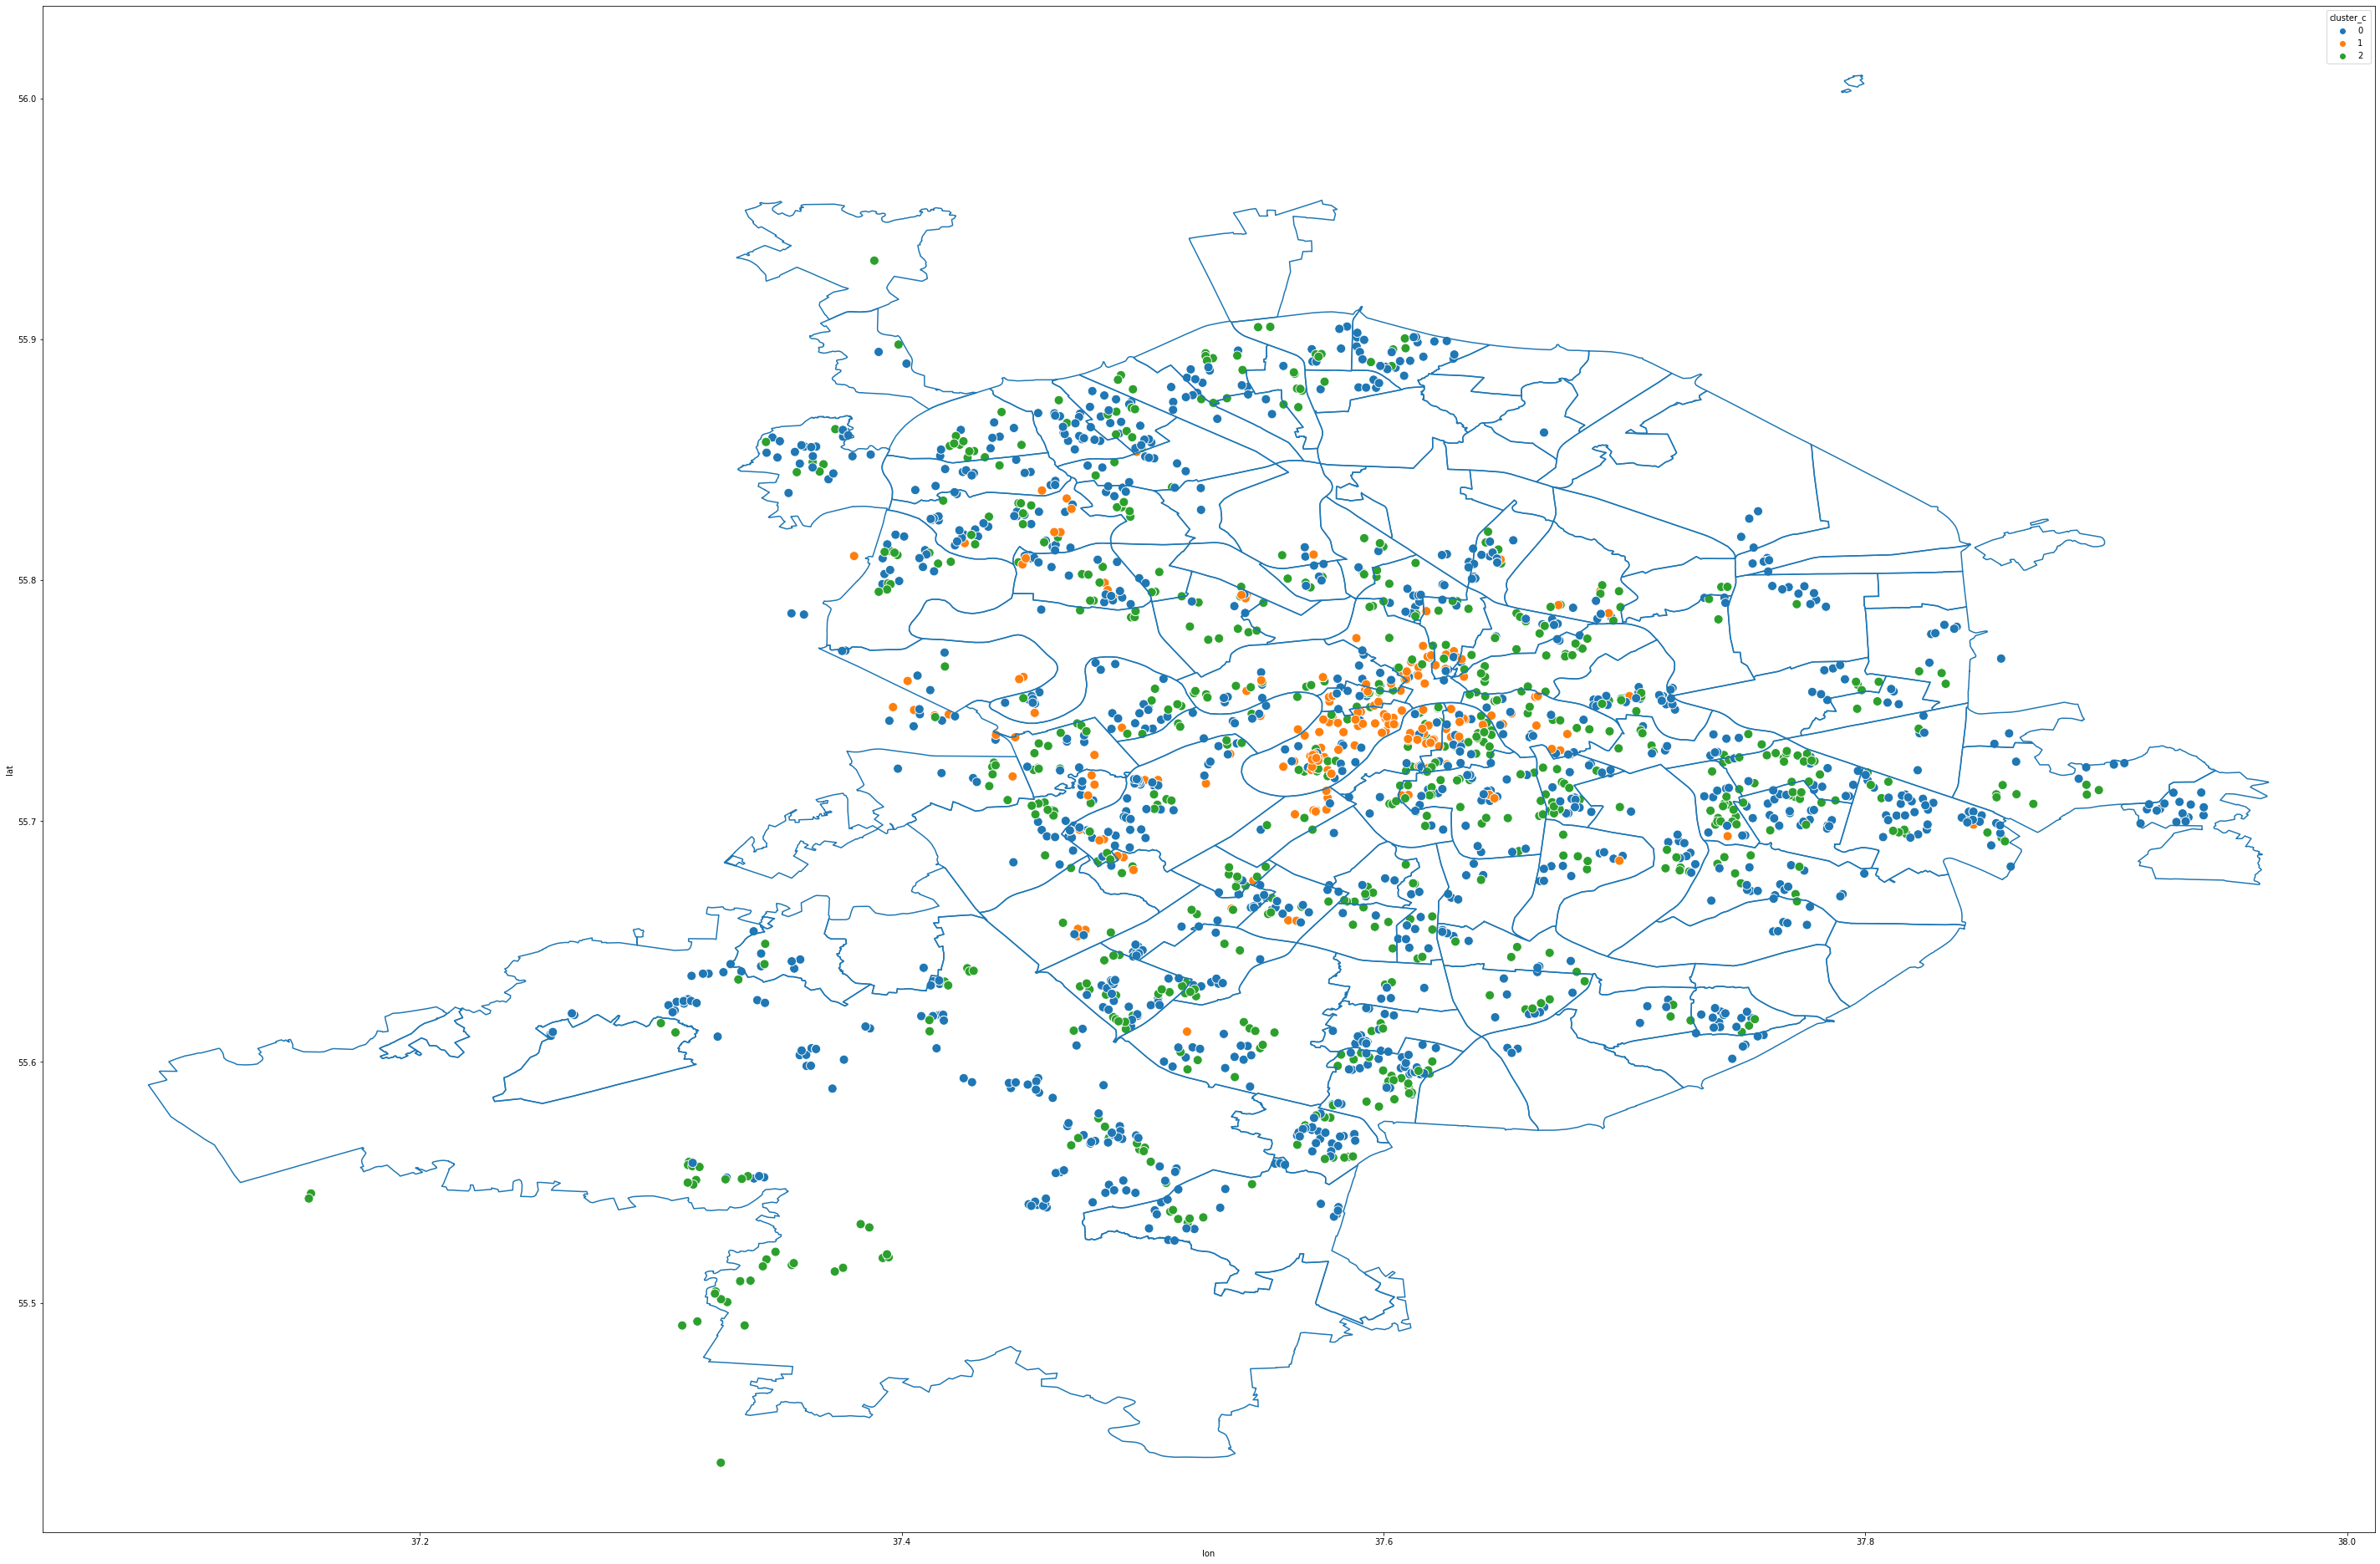

In [32]:
# создаем большой график 50 на 50 дюймов
# в fig остается изображение, которое выгрузим в файл, 
# в axes хранятся оси для редактирования


fig, axes = plt.subplots(figsize = (50, 50))

# строим карту в осях axes
df_geo.boundary.plot(ax = axes);

# в тех же осях axes строим диаграмму рассеивания
sns.scatterplot(data = flats, x = "lon", y = "lat", 
                hue = "cluster_c", s = 120, ax = axes);

**Пояснения.** Долготу `lon` (*longitude*) отмечаем по горизонтальной оси, широту `lat` (*latitude*) – по вертикальной. Цвет точек `hue` зависит от принадлежности к кластеру – метки в столбце `cluster_c`,  размер точек `s` увеличиваем до 120. 

Итого: хотя мы и взяли не очень большую выборку квартир, заметно, что дорогие квартиры из второго кластера (номер 1, оранжевые точки) располагаются, за редким исключением, в центре Москвы, причем в пределах Бульварного кольца (плюс район Хамовники), «среднестатистические» квартиры из третьего кластера (номер 2, зеленые точки) чаще встречаются на юге и юго-востоке Москвы и в Новой Москве.

**Дополнение (не запускайте, если переживаете за компьютер).** Кластеризуем все квартиры из исходного файла:

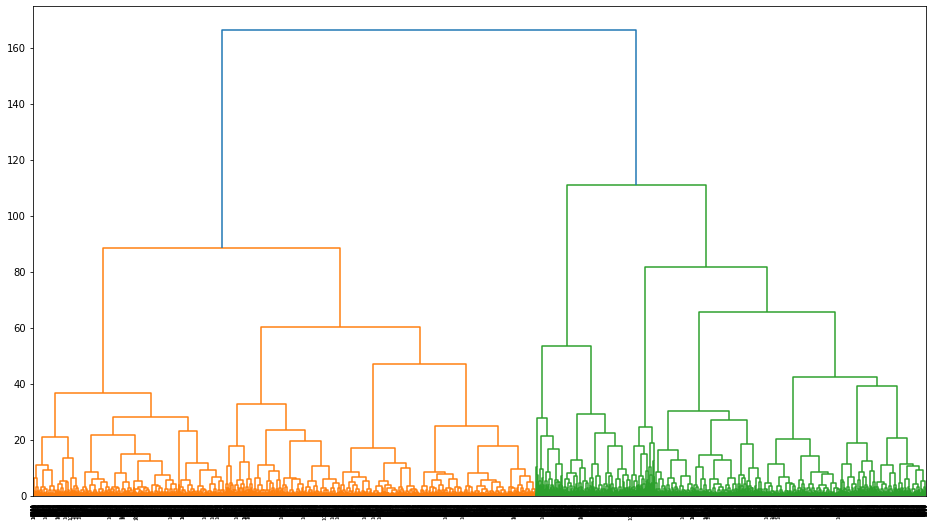

In [33]:
# нормируем
X_full = scaler.fit_transform(df[["lprice", "square", "rooms", "floor", "dmetro"]])

# запускаем кластеризацию (примерно 5 минут)
hc = linkage(X_full, method = "ward")
plt.figure(figsize = (16, 9))
dendrogram(hc);

In [34]:
# сохраняем метки кластеров
df["cluster"] = cut_tree(hc, n_clusters = 3).reshape(-1, ).astype(str)

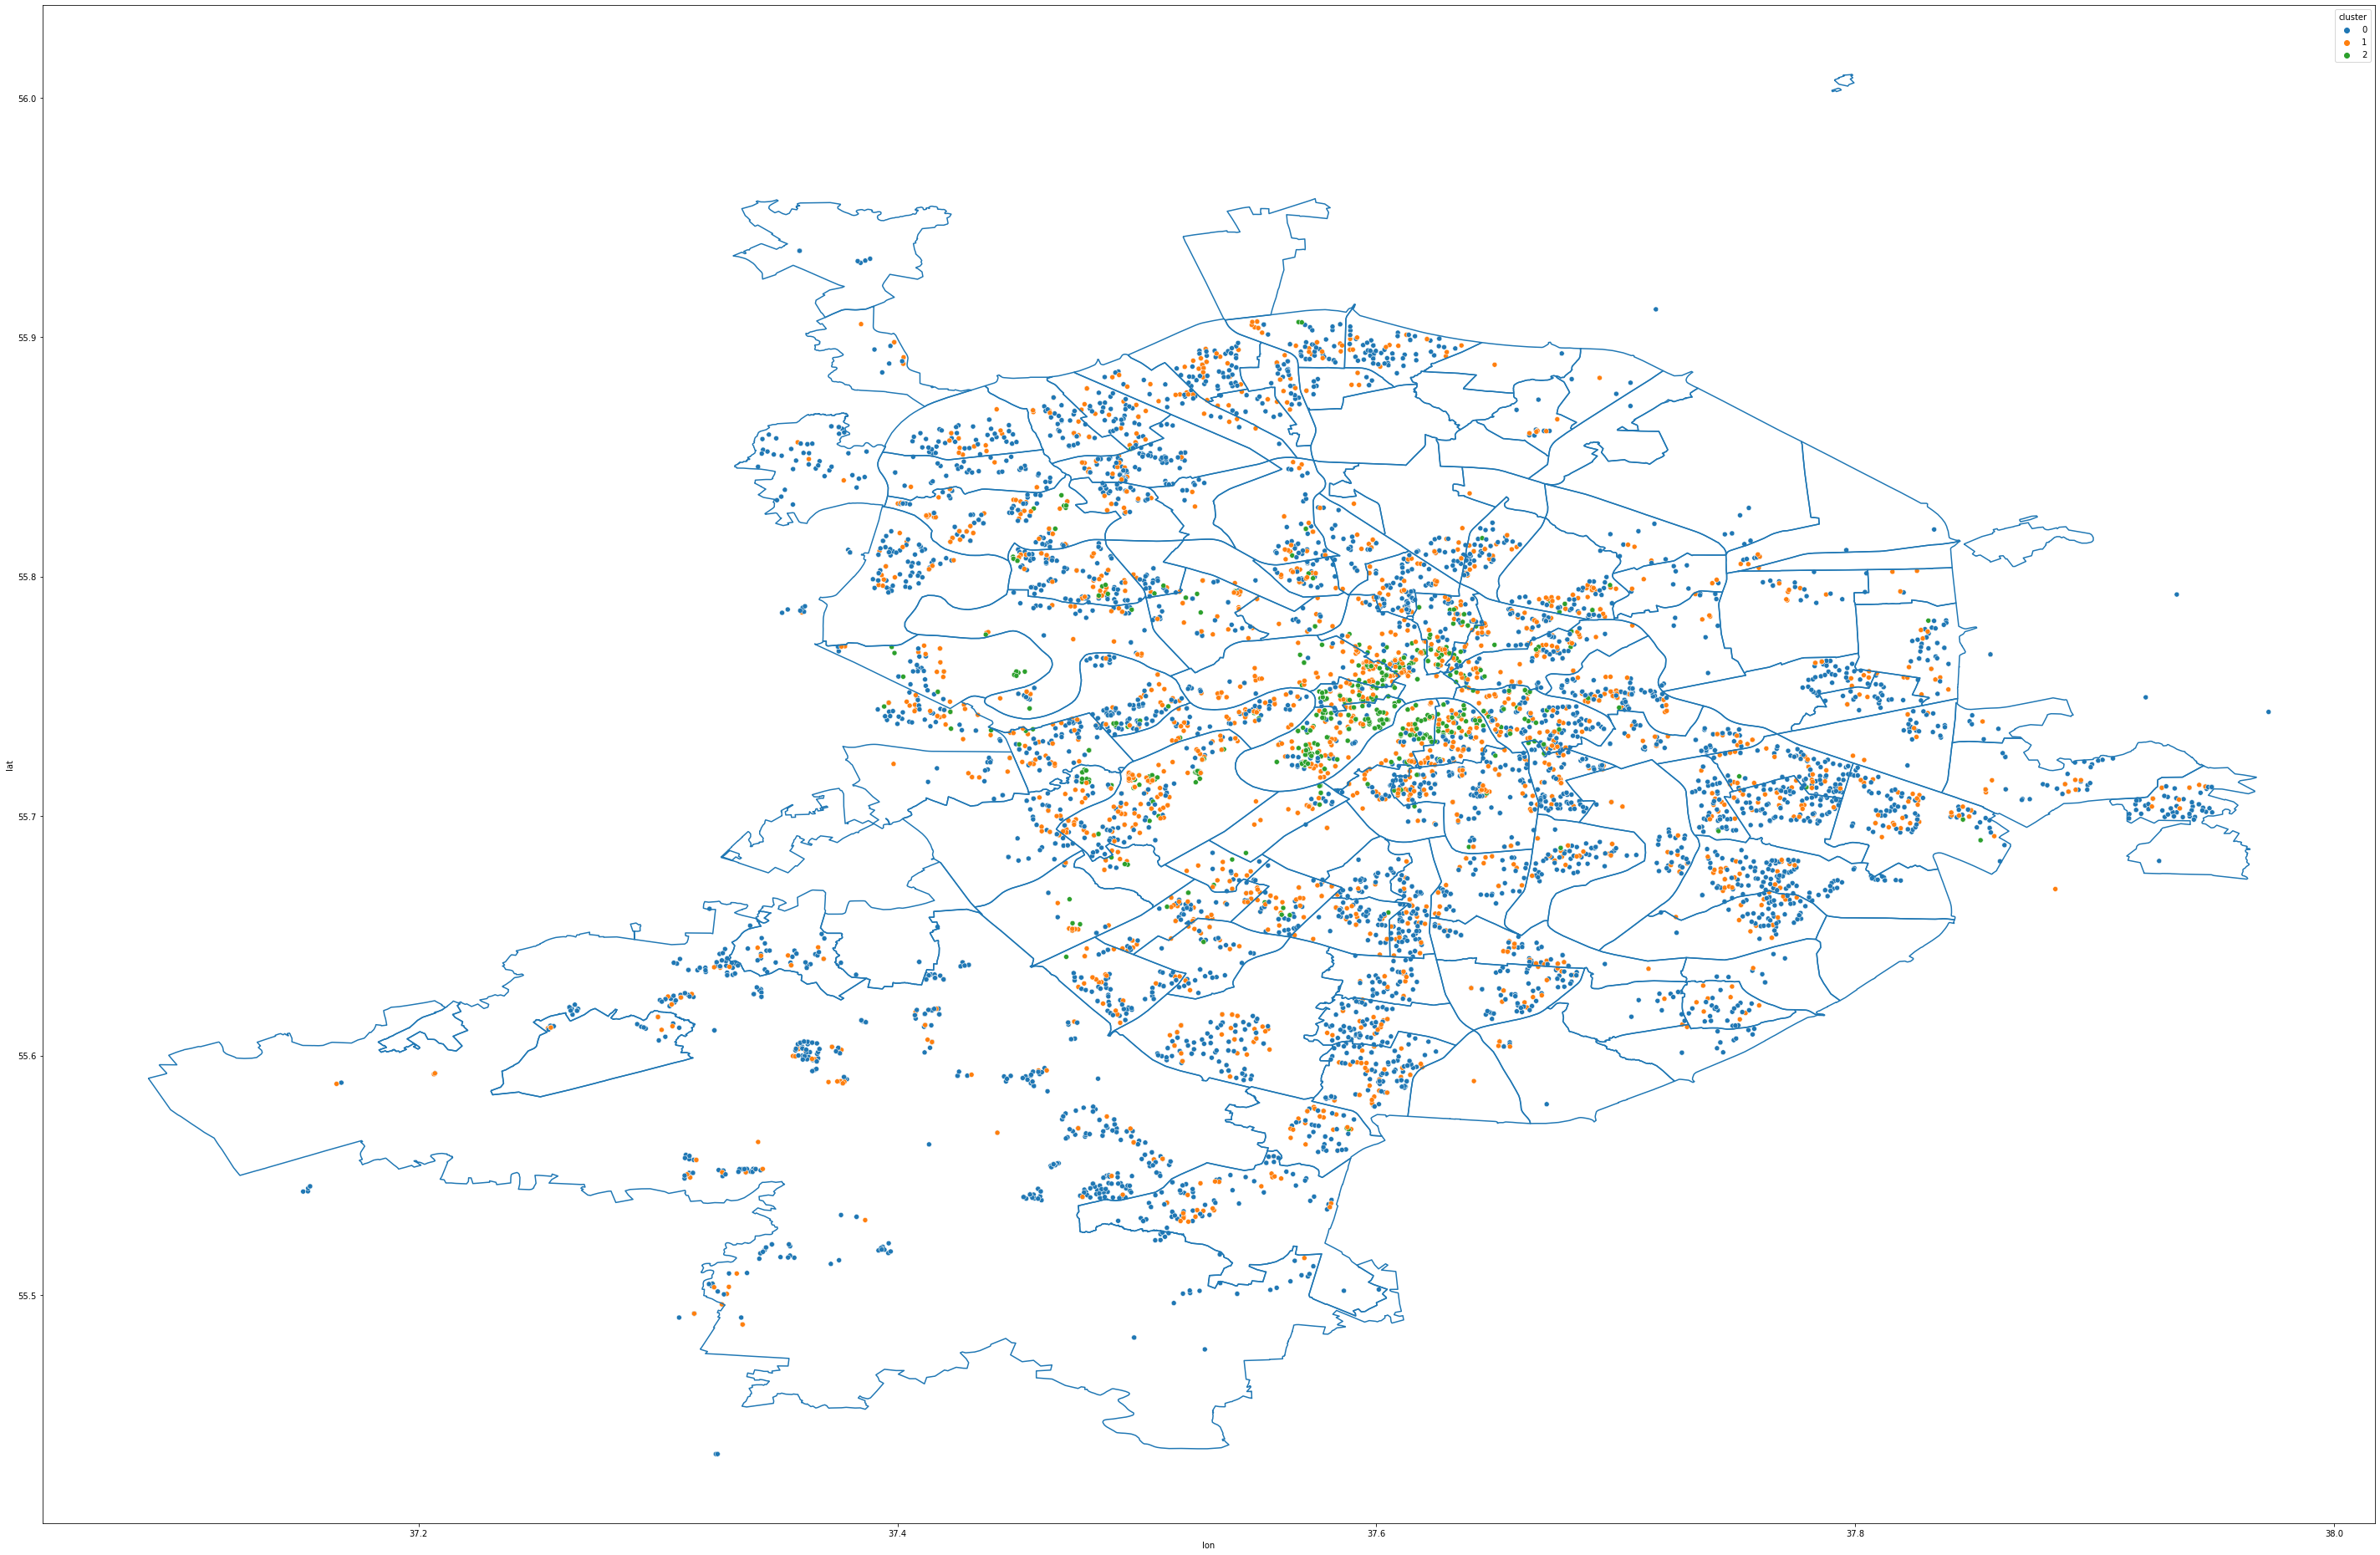

In [35]:
# наносим все на карту

fig, axes = plt.subplots(figsize = (50, 50))
df_geo.boundary.plot(ax = axes);
sns.scatterplot(data = df , x = "lon", y = "lat", hue = "cluster", ax = axes);

Цвета точек изменились, но точки в пределах кольца вместе с Хамовниками по-прежнему выделяются. Можем сохранить карту в файл:

In [38]:
fig.savefig("map.pdf")